In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=70aba691b9937065a08cd777f626c20cfb5053e2028aceedf1b26732c8127b3c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import wget
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.losses import BinaryCrossentropy,mean_squared_error
from sklearn.metrics import roc_curve, auc, accuracy_score
import math

OBTENCIÓN DE LOS DATOS MUESTRALES A TRAVÉS DE PANDAS


In [3]:
files=['https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
]

In [4]:
for f in files:
    if not os.path.exists('./%s'%os.path.basename(f)): # so that we can rerun this without worrying of duplicate downloads
        wget.download(f, './%s'%os.path.basename(f))

In [5]:
data = pd.read_csv('winequality-red.csv', delimiter=';')

Visualize the first five entries

In [6]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
data = data.sample(frac=1).reset_index(drop=True)

ASOCIAMOS UN LABEL CATEGÓRICO QUE LLEVE 'BUEN VINO' A '1' Y 'MAL VINO' A '0'![Data GOD.png](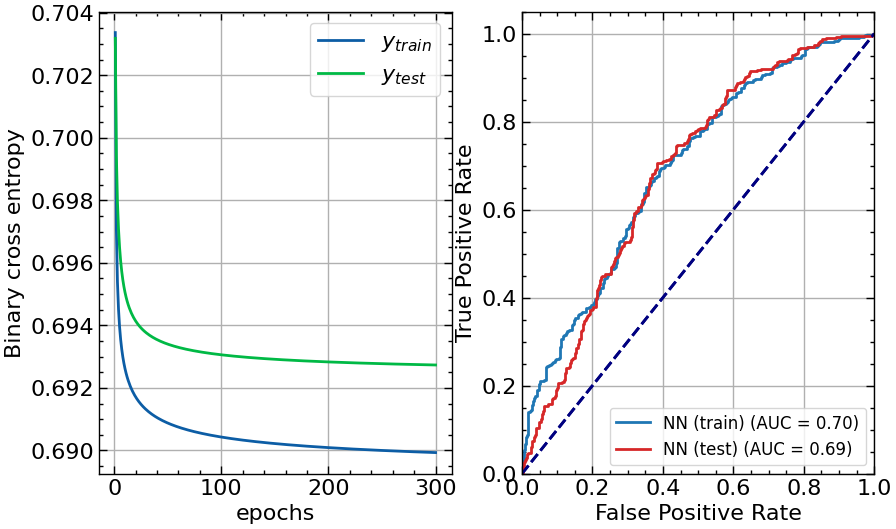![aucMejorINTENTO.png](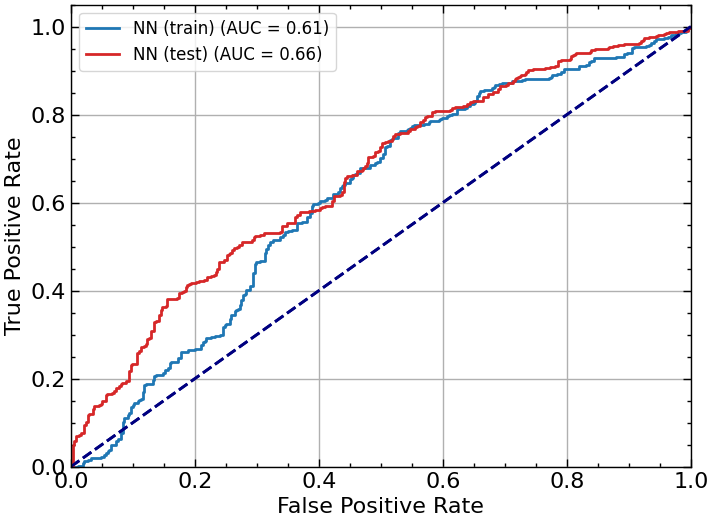![Ej1MV.png](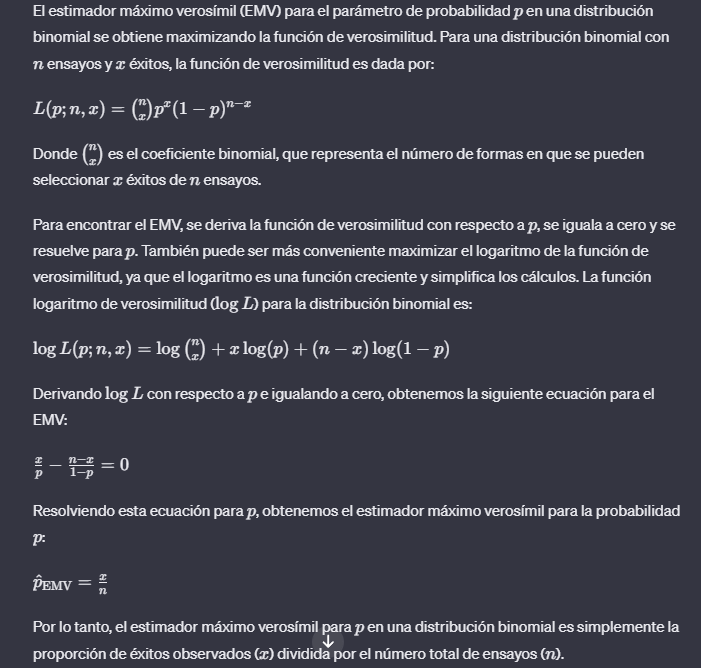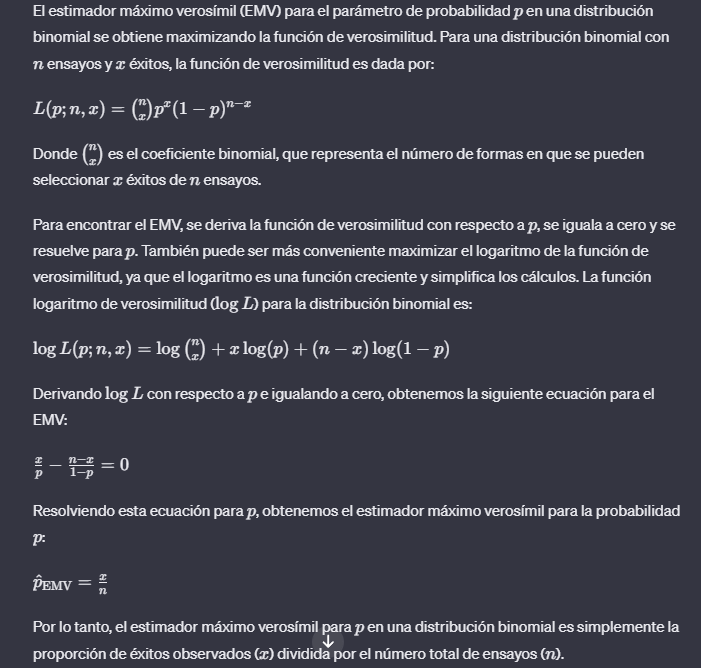)))



In [86]:
data['label'] = data['quality'].apply(lambda x: 0 if x in [3,4] else 1)

In [87]:
data_tr=data.head(int(len(data)/2))
data_te=data.tail(len(data)-int(len(data)/2))

FUNCIONES DE ACTIVACIÓN

In [10]:
def sigmoid(entrada):
    return 1/(1+np.exp(-entrada))

In [11]:
def sigmoid_derivative(entrada):
    return sigmoid(entrada) * (1 - sigmoid(entrada))

In [12]:
def relu(Z):
    A = np.maximum(0, Z)
    return A

In [13]:
def relu_derivada(Z):
    dA = np.where(Z > 0, 1, 0)
    return dA

In [14]:
def tanh(Z):
    A = np.tanh(Z)
    return A

In [15]:
def tanh_derivada(Z):
    A = np.tanh(Z)
    dA = 1 - np.square(A)
    return dA

LEARNING RATE

In [16]:
def learning_rate(epoch):
    default_lr = 0.001
    epochs_drop = 5.0
    drop = 0.8
    # lr = default_lr*math.pow(drop,math.floor(epoch/epochs_drop))
    lr = default_lr**2/epoch
    return lr

In [17]:
print('Sanity check: ', len(data), '==', len(data_tr), '+', len(data_te),': ', len(data)==len(data_tr)+len(data_te))

Sanity check:  1599 == 799 + 800 :  True


SEPARACIÓN DE LOS DATASETS EN X_train e Y_train

In [88]:
y_train = np.array(data_tr['label']) #Dividimos entre diez para mejorar convergencia
x_train = data_tr.drop(['label'], axis=1).T
y_test  = np.array(data_te['label'])#Dividimos entre diez para mejorar convergencia
x_test  = data_te.drop(['label'], axis=1).T

DEFINIMOS LA RED NEURONAL

In [19]:
def RedNeuronal(y_train,x_train,n_neuronas,act_func,act_func_derivative,lab_legend='$y_{train}$'):
    n_inputs = x_train.shape[0]
    n_hidden = n_neuronas
    n_output = 1

    epochs = 300
    J = []
    # J_MSE = []

    w_entrada = np.random.normal(0,0.1, size=(n_inputs,n_hidden)).T #(20,11)
    w_salida = np.random.normal(0,0.1,size = (n_hidden,n_output))    #(20,1)

    bce = BinaryCrossentropy()

    for _ in range(1,epochs+1):

      z = act_func(w_entrada[:,0] + (np.dot(w_entrada,x_train).T)) #(799,20)

      y = act_func((np.dot(w_salida.T,z.T).T + w_salida[0,:].T))   #(799,1)

      error_salida = np.dot(y_train-y,act_func_derivative(y))        #(799,1)
      error_entrada = (np.dot(w_salida,error_salida.T)*act_func_derivative(z).T).T  #(799,20)

      w_entrada  = w_entrada + learning_rate(_)*np.dot(error_entrada.T,x_train.T)  #(20,11)
      w_salida = w_salida + learning_rate(_)*np.dot(error_salida.T,z).T            #(20,1)

      J.append(bce(y_train,y))
      # J_MSE.append(np.mean(y_train-y)**2)

    x = np.linspace(1,epochs,epochs)

    # plt.plot(x,J_MSE,label = 'MSE')
    plt.plot(x,J,label=lab_legend)
    plt.xlabel('epochs')
    plt.ylabel('Binary cross entropy')
    plt.legend(loc='best',frameon= True)
    return y

FUNCIÓN QUE PLOTEA LA CURVA_ROC

In [20]:
def plot_rocs(scores_and_names, y,color = 'black',title=False):
    pack=[]
    AUC = []
    for s, n in scores_and_names:
        fpr, tpr, thresholds = roc_curve(y.ravel(), s)
        pack.append([n, fpr,tpr,thresholds])
    lw=2
    for n, fpr, tpr, thresholds in pack:
        plt.plot(fpr, tpr, lw=lw,color=color, label="%s (AUC = %0.2f)" % (n, auc(fpr, tpr)))
        AUC.append(auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if title == True:
      plt.title("Receiver Operating Characteristic curve")
    plt.legend(frameon=True,fontsize=12,loc="best")
    return np.round(AUC,decimals=2)


<br>
predict_train y predict_test son las predicciones de la red neuronal<br>


In [89]:
act_func = sigmoid
act_func_derivative = sigmoid_derivative

In [41]:
#act_func = tanh
#act_func_derivative = tanh_derivada

In [42]:
#act_func = relu
#act_func_derivative = relu_derivada

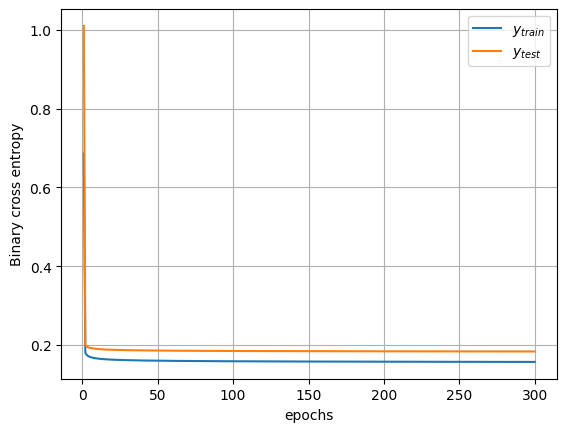

In [90]:
plt.figure()
plt.grid()
NN_train = RedNeuronal(y_train,x_train,35,act_func,act_func_derivative)
NN_test = RedNeuronal(y_test,x_test,35,act_func,act_func_derivative,'$y_{test}$')
plt.show()

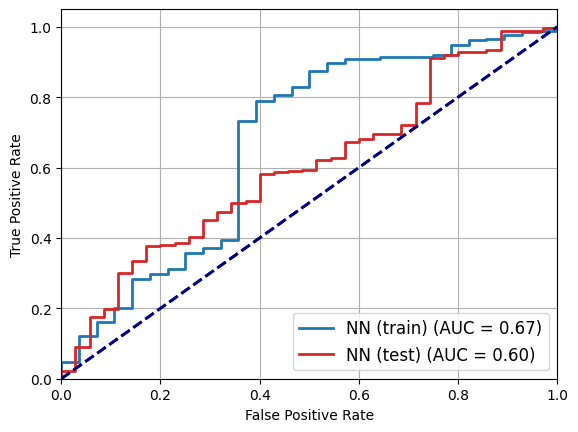

In [91]:
plt.figure()
plt.grid()
plot_rocs([[NN_train, 'NN (train)'  ]],y_train,'tab:blue')
plot_rocs([[NN_test, 'NN (test)'  ]], y_test,'tab:red')
plt.show()

In [ ]:
NN_train.save('NN_Train.h5')
NN_test.save('NN_Test.h5')

A continuación se muestra un ejemplo de una de las redes entrenadas que dan buenos resultados. No es tarea trivial encontrar redes que clasifiquen bien este problema.

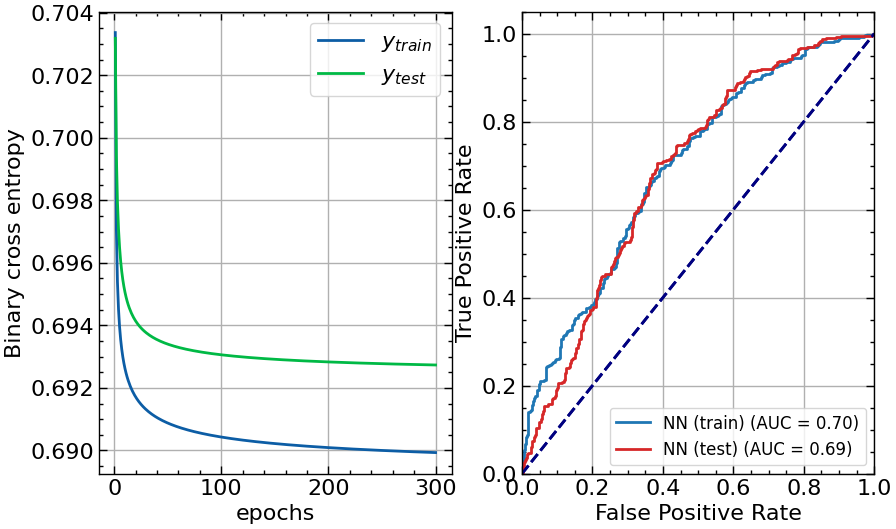

In [30]:
from IPython.display import Image

# Ruta de la imagen en Google Colab
imagen_path = '/content/sample_data/Data GOD.png'

# Muestra la imagen en el notebook
Image(filename=imagen_path)